<a href="https://colab.research.google.com/github/rafaelpivetta/machine-learning/blob/main/classificacao_estorno_rfc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install skl2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.2 which is incompatible.
tensorflow 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
grpcio-status 1.62.3 requires protobuf>=4.

In [ ]:
import pandas as pd
import numpy as np

# Bibliotecas para modelagem e avaliação
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# 1. Leitura e preparação dos dados
# Exemplo: leitura do dataset
df = pd.read_csv('deteccao-fraude-estorno.csv')

# Converte a coluna "hora_fim_expediente" para datetime, usando apenas o formato de hora
df['hora_fim_expediente'] = pd.to_datetime(df['hora_fim_expediente'], format='%H:%M:%S')

# Extrai o total de minutos desde a meia-noite
df['hora_fim_expediente_minutos'] = (
    df['hora_fim_expediente'].dt.hour * 60 +
    df['hora_fim_expediente'].dt.minute
)

# Converter a coluna de data/hora e extrair a hora do estorno
df['hora_estorno_minutos'] = pd.to_datetime(df['dh_estorno']).dt.hour * 60 + pd.to_datetime(df['dh_estorno']).dt.minute

df.head()

,transacao,loja,status,valor,dh_pagamento,dh_estorno,dif_minutos,hora_fim_expediente,fraude,hora_fim_expediente_minutos,hora_estorno_minutos
0,1103,6,ESTORNADO,25.50,2024-09-16 16:27:38.910000,2024-09-16 19:34:57.287000,187,1900-01-01 15:00:00,1,900,1174
1,1115,6,ESTORNADO,29.00,2024-09-11 14:16:45.427000,2024-09-11 19:29:29.905000,312,1900-01-01 15:00:00,1,900,1169
2,1099,5,ESTORNADO,19.05,2024-11-28 16:58:26.353000,2024-11-28 20:12:07.534000,193,1900-01-01 17:00:00,1,1020,1212
3,1101,5,ESTORNADO,39.50,2024-02-23 16:45:40.512000,2024-02-23 20:07:16.365000,201,1900-01-01 17:00:00,1,1020,1207
4,1072,4,ESTORNADO,58.20,2024-10-16 16:33:23.499000,2024-10-16 19:54:11.184000,200,1900-01-01 16:30:00,1,990,1194


In [ ]:
df.drop(columns=['transacao', 'status', 'dh_pagamento', 'dh_estorno', 'hora_fim_expediente'], inplace=True)
df.head()

,loja,valor,dif_minutos,fraude,hora_fim_expediente_minutos,hora_estorno_minutos
0,6,25.50,187,1,900,1174
1,6,29.00,312,1,900,1169
2,5,19.05,193,1,1020,1212
3,5,39.50,201,1,1020,1207
4,4,58.20,200,1,990,1194


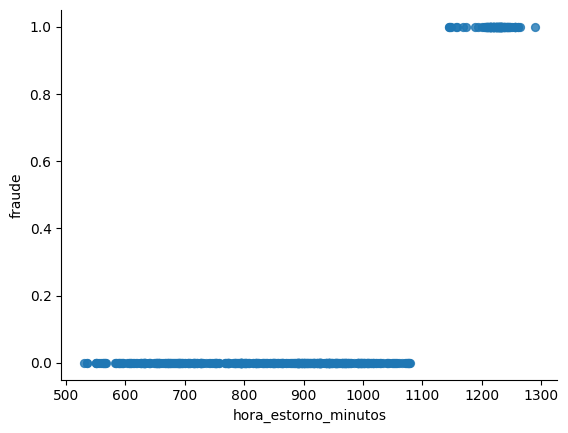

In [ ]:
from matplotlib import pyplot as plt
df.plot(kind='scatter', x='hora_estorno_minutos', y='fraude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

                                 loja     valor  dif_minutos    fraude  \
loja                         1.000000 -0.113535    -0.168621 -0.186786   
valor                       -0.113535  1.000000     0.092477  0.092184   
dif_minutos                 -0.168621  0.092477     1.000000  0.828769   
fraude                      -0.186786  0.092184     0.828769  1.000000   
hora_fim_expediente_minutos -0.068056  0.034956    -0.189572 -0.270287   
hora_estorno_minutos        -0.171126  0.136751     0.703771  0.793874   

                             hora_fim_expediente_minutos  hora_estorno_minutos  
loja                                           -0.068056             -0.171126  
valor                                           0.034956              0.136751  
dif_minutos                                    -0.189572              0.703771  
fraude                                         -0.270287              0.793874  
hora_fim_expediente_minutos                     1.000000             -0.1567

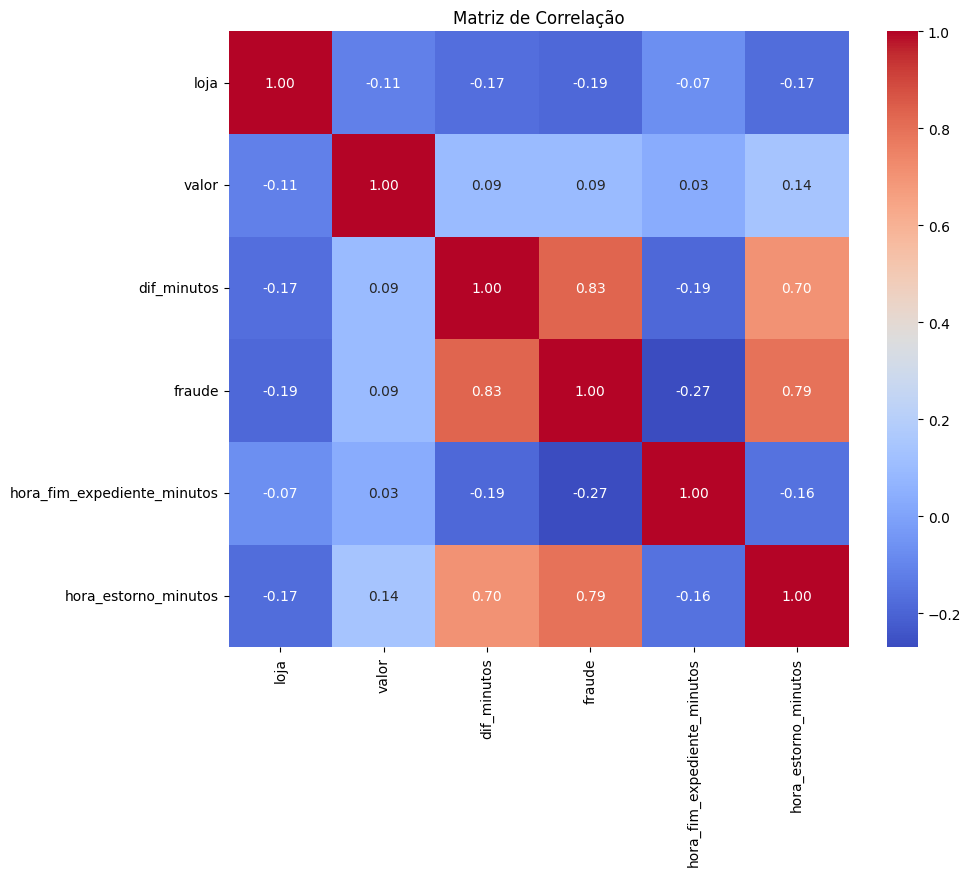

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supondo que 'df' seja o seu DataFrame com as variáveis numéricas
correlation_matrix = df.corr()

# Exibe a matriz de correlação
print(correlation_matrix)

# Visualiza a matriz de correlação com um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

In [ ]:
# 2. Seleção de features
features = ['loja', 'valor', 'dif_minutos', 'hora_fim_expediente_minutos', 'hora_estorno_minutos']
X = df[features]
y = df['fraude']  # Já está codificado como 0 ou 1

# Divisão do dataset em treino (80%) e teste (20%), mantendo a proporção das classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Pré-processamento com ColumnTransformer
# Todas as features são numéricas, então aplicamos apenas o StandardScaler.
numeric_features = features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough',  # Mantém os nomes originais
    verbose_feature_names_out=False  # Evita nomes como 'num__loja'
)

# 4. Construção do pipeline: pré-processamento + Random Forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 5. Otimização dos hiperparâmetros com GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='precision',  # Priorizando precisão para reduzir falsos positivos
    n_jobs=-1,
    verbose=1
)

# Treinamento do modelo com validação cruzada
grid_search.fit(X_train, y_train)
print("Melhores parâmetros:", grid_search.best_params_)

# 6. Avaliação do Modelo
y_pred = grid_search.predict(X_test)

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])
print("AUC-ROC:", roc_auc)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Melhores parâmetros: {'classifier__bootstrap': True, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        81
           1       1.00      1.00      1.00        23

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104

Matriz de Confusão:
[[81  0]
 [ 0 23]]
AUC-ROC: 1.0


In [30]:
# 7. Exemplo de novos dados de entrada para validação

# String de entrada
input_str = "12|180.76|100|1020|1120"

# Divide a string usando o caractere '|' como delimitador
parametros = input_str.split("|")

# Converte cada parte para o tipo numérico apropriado:
loja = float(parametros[0])
valor = float(parametros[1])
dif_minutos = float(parametros[2])
hora_fim_expediente_minutos = float(parametros[3])
hora_estorno_minutos = float(parametros[4])

# Cria o DataFrame com as colunas esperadas pelo modelo
df_teste = pd.DataFrame({
    'loja': [loja],
    'valor': [valor],
    'dif_minutos': [dif_minutos],
    'hora_fim_expediente_minutos': [hora_fim_expediente_minutos],
    'hora_estorno_minutos': [hora_estorno_minutos]
})

print("DataFrame criado:")
print(df_teste)

# Selecionar as features usadas no modelo
df_teste_features = df_teste[['loja', 'valor', 'dif_minutos', 'hora_fim_expediente_minutos', 'hora_estorno_minutos']]

# Realizar predições para os novos dados
predicoes = grid_search.predict(df_teste_features)
probabilidade_class_1 = grid_search.predict_proba(df_teste_features)[:, 1]
probabilidade_class_0 = grid_search.predict_proba(df_teste_features)[:, 0]

print("\nNovos dados para validação:")
print(df_teste_features)
print("\nPredições (0 = Não fraude, 1 = Fraude):", predicoes)
print("Probabilidades fraude:", probabilidade_class_1)
print("Probabilidades não fraude:", probabilidade_class_0)

DataFrame criado:
   loja   valor  dif_minutos  hora_fim_expediente_minutos  \
0  12.0  180.76        100.0                       1020.0   

   hora_estorno_minutos  
0                1120.0  

Novos dados para validação:
   loja   valor  dif_minutos  hora_fim_expediente_minutos  \
0  12.0  180.76        100.0                       1020.0   

   hora_estorno_minutos  
0                1120.0  

Predições (0 = Não fraude, 1 = Fraude): [1]
Probabilidades fraude: [0.77]
Probabilidades não fraude: [0.23]


In [ ]:
# Para converter o modelo em ONNX
import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# 6. Conversão para ONNX (usando o melhor estimador do GridSearch)
best_model = grid_search.best_estimator_

# Definindo o formato de entrada: (None, número de features)
# initial_type = [('input', FloatTensorType([None, len(features)]))]
# 'loja', 'valor', 'dif_minutos', 'hora_fim_expediente_minutos', 'hora_estorno_minutos'
initial_type = [
    ('loja', FloatTensorType([None, 1])),
    ('valor', FloatTensorType([None, 1])),
    ('dif_minutos', FloatTensorType([None, 1])),
    ('hora_fim_expediente_minutos', FloatTensorType([None, 1])),
    ('hora_estorno_minutos', FloatTensorType([None, 1]))
]

onnx_model = convert_sklearn(best_model, initial_types=initial_type)

with open("predicao_estorno_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("Modelo ONNX salvo em 'predicao_estorno_model.onnx'")

Modelo ONNX salvo em 'predicao_estorno_model.onnx'
